In [36]:
import pangolin
from pangolin import transforms
from pangolin.interface import (
    vmap, normal_scale, normal, RV, VMapDist,
    makerv, viz_upstream, exponential, bernoulli, print_upstream,
    Constant, Index, exp, multi_normal_cov, dirichlet, Sum, bernoulli_logit,
    categorical
)
from pangolin import Calculate
from pangolin import dag
import jax
from jax.tree_util import tree_map, tree_flatten
from jax import numpy as jnp
from jax.random import PRNGKey
# from itertools import groupby
import time
import numpy as np
from collections import defaultdict
from contrib import AutoVmap
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [12]:
def AutoVmapWrap(vars, given_vars=[], given_vals=[], order=0):
    vars, tree_def = tree_flatten(vars)
    given_vars = tree_flatten(given_vars)[0]
    given_vals = tree_flatten(given_vals)[0]
    transformed_var, transformed_given_var, transformed_given_vals = AutoVmap(
        vars, given_vars, given_vals, order
    )
    return transformed_var

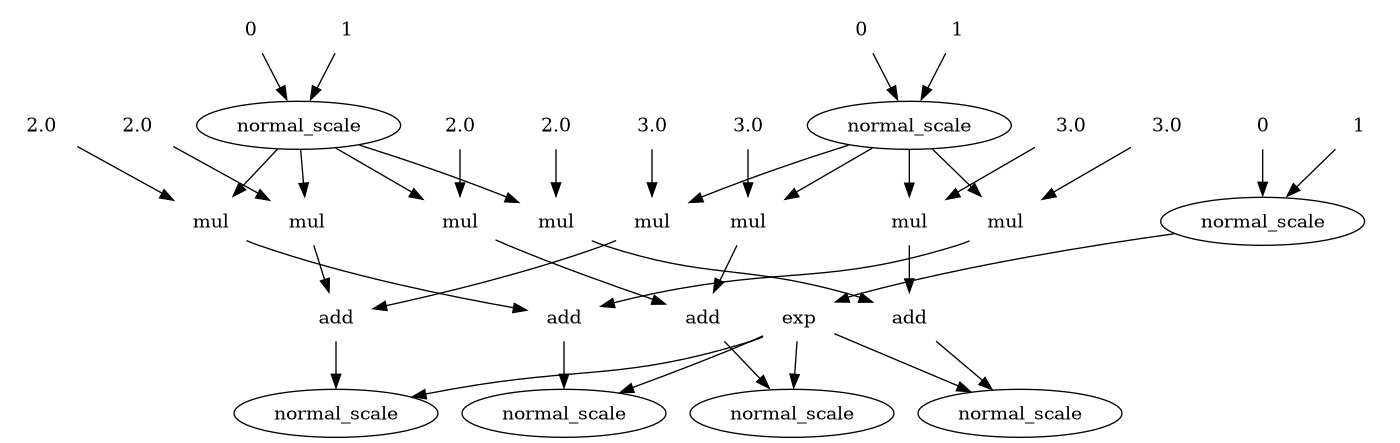

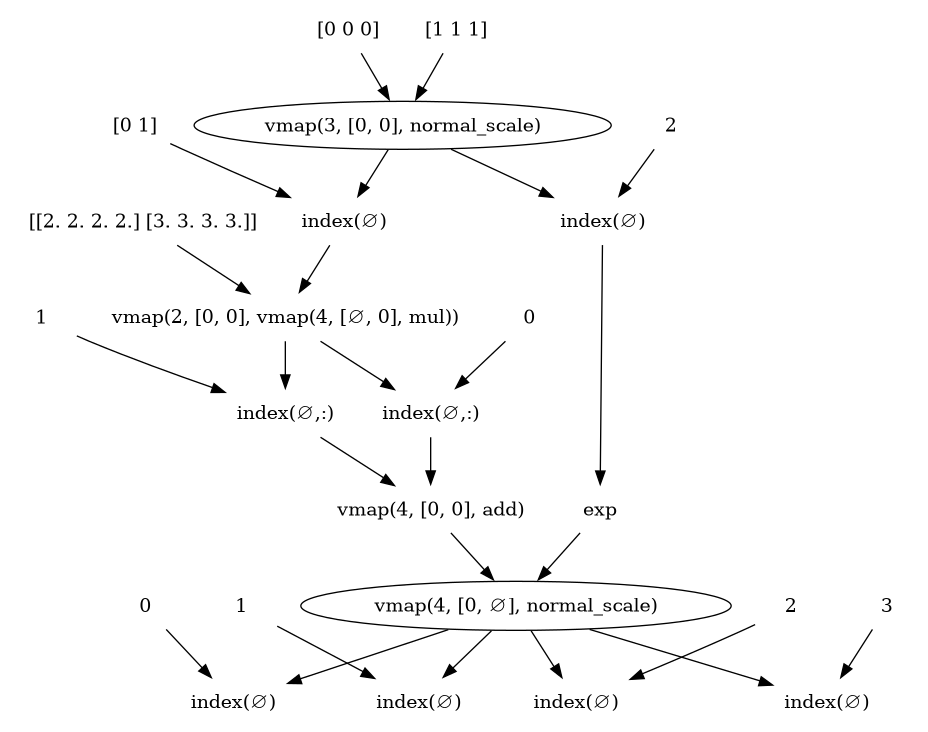

In [23]:
w1 = normal_scale(0, 1)
w2 = normal_scale(0, 1)
sigma = exp(normal_scale(0, 1))
x = [normal_scale(w1 * 2.0 + w2 * 3.0, sigma) for _ in range(4)]
display(viz_upstream(x))
display(viz_upstream(AutoVmapWrap(x, order=-1)))

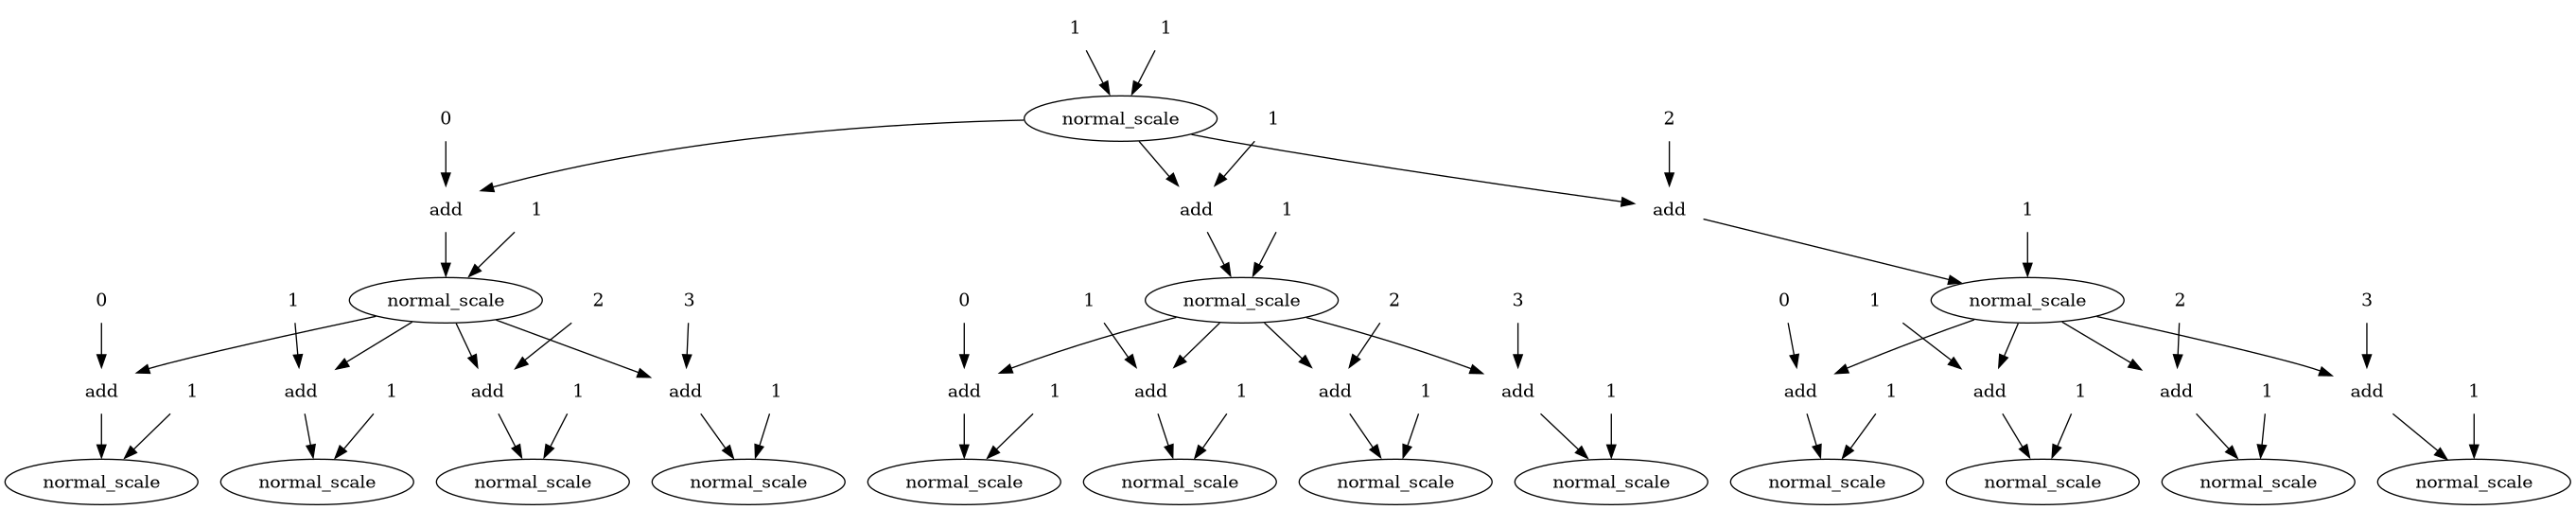

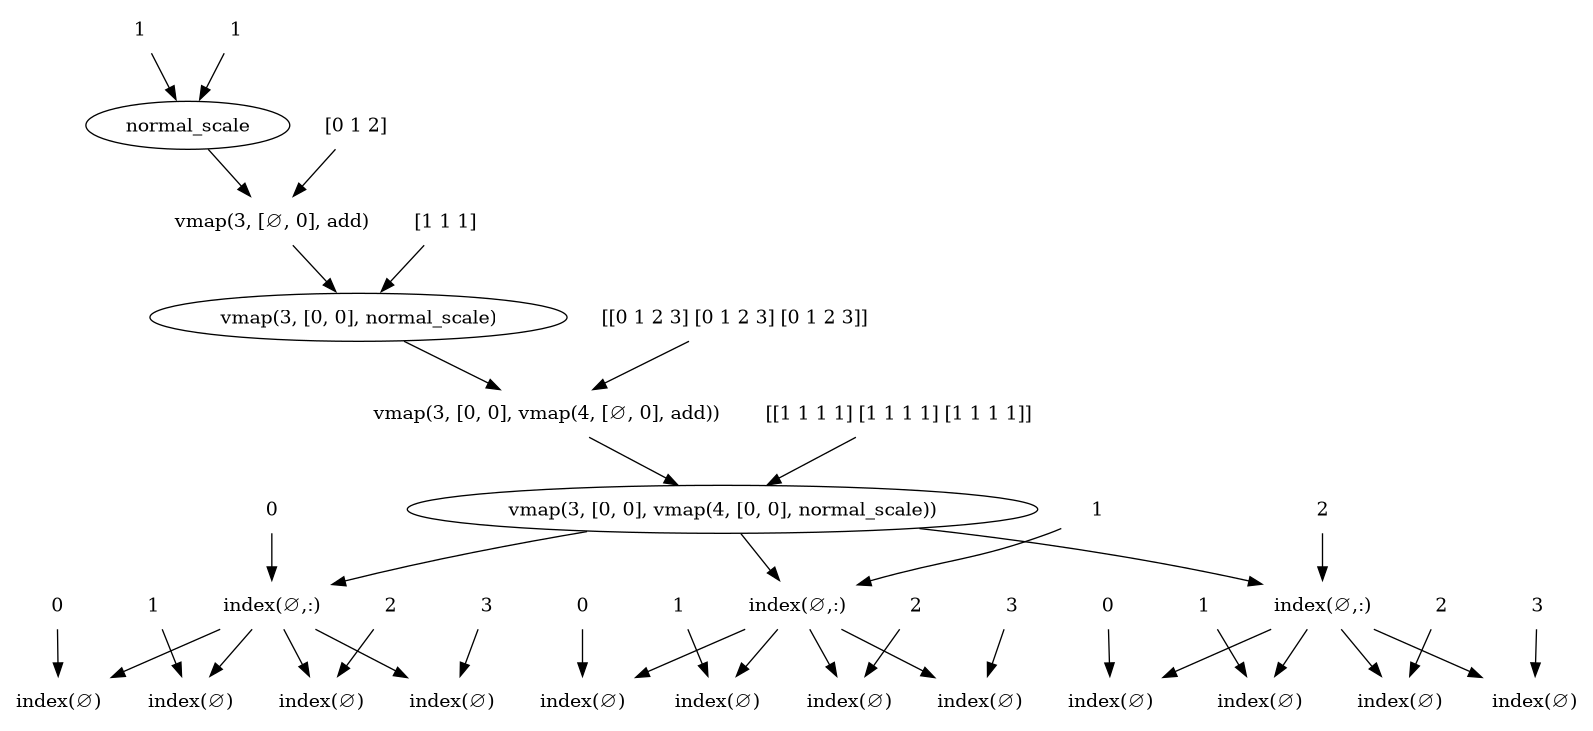

In [22]:
x = normal(1,1)
y = [normal(x + i,1) for i in range(3)]
z = [[normal(yi + i,1) for i in range(4)] for yi in y]

display(viz_upstream(z))
viz_upstream(AutoVmapWrap(z, order=-1))

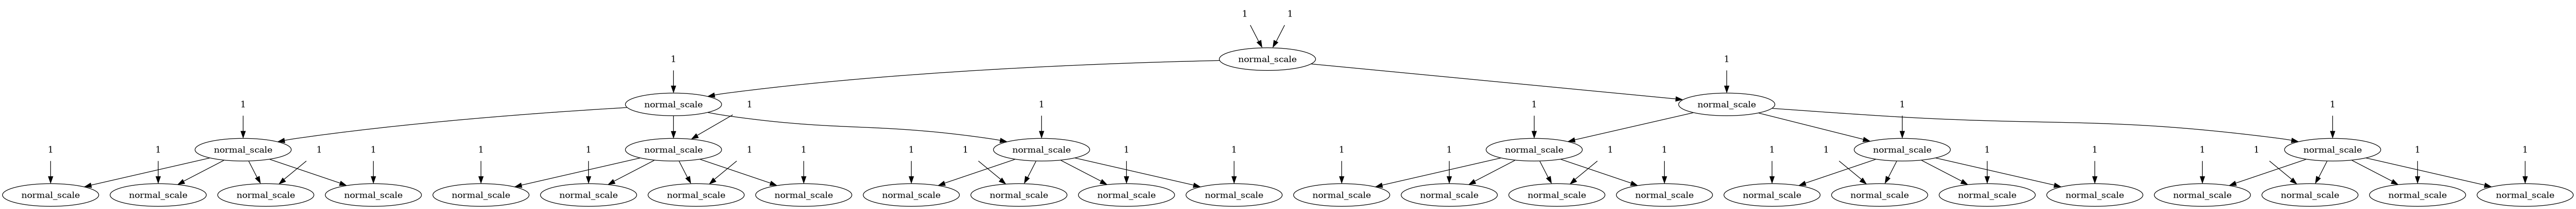

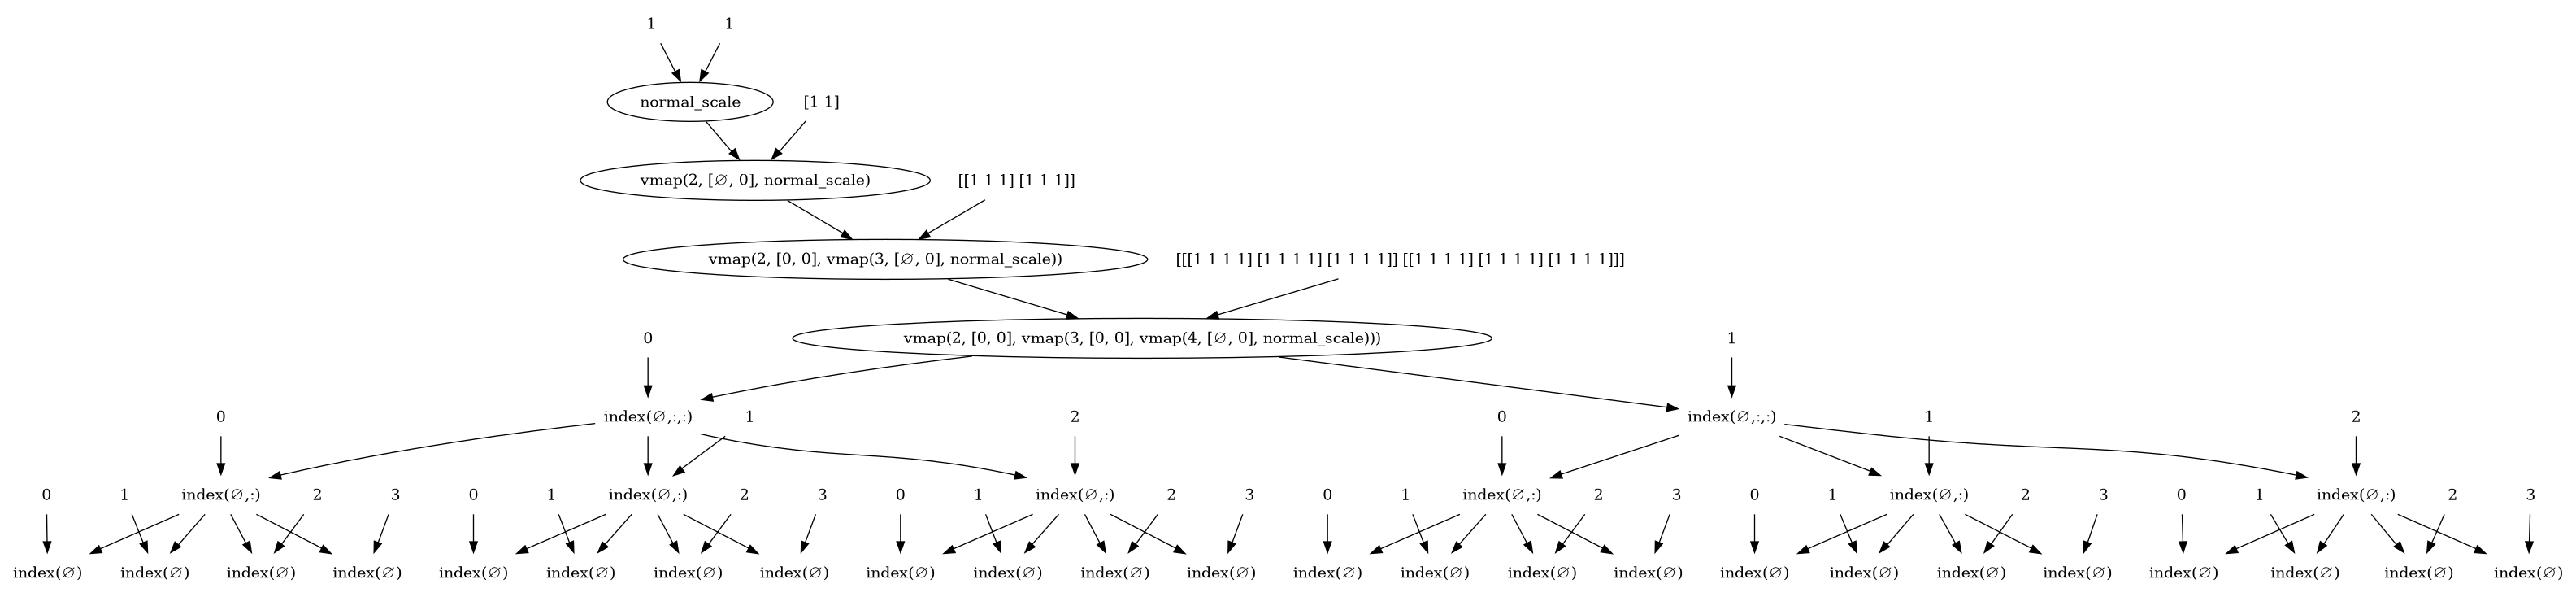

In [21]:
x = normal(1,1)
y = []
z = []
u = []
for i in range(2):
    yi = normal(x, 1)
    y.append(yi)
    for j in range(3):
        zi = normal(yi, 1)
        z.append(zi)
        for k in range(4):
            ui = normal(zi, 1)
            u.append(ui)

display(viz_upstream(u))
viz_upstream(AutoVmapWrap(u, order=-1))

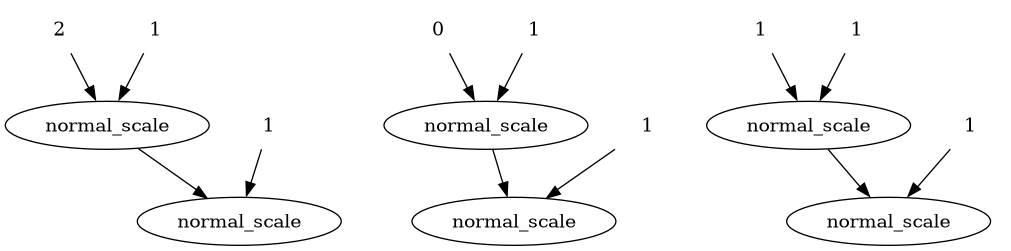

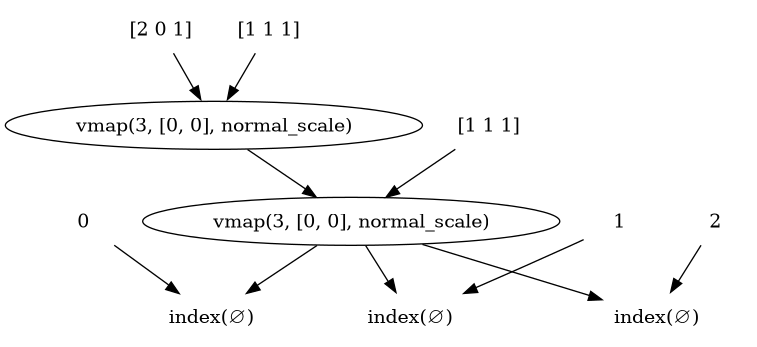

In [20]:
x = [normal(i,1) for i in range(3)]
y = [normal(x[0],1), normal(x[1],1), normal(x[2],1)]
z = [normal(x[2],1), normal(x[0],1), normal(x[1],1)]
display(viz_upstream(z))
display(viz_upstream(AutoVmapWrap(z, order=-1)))

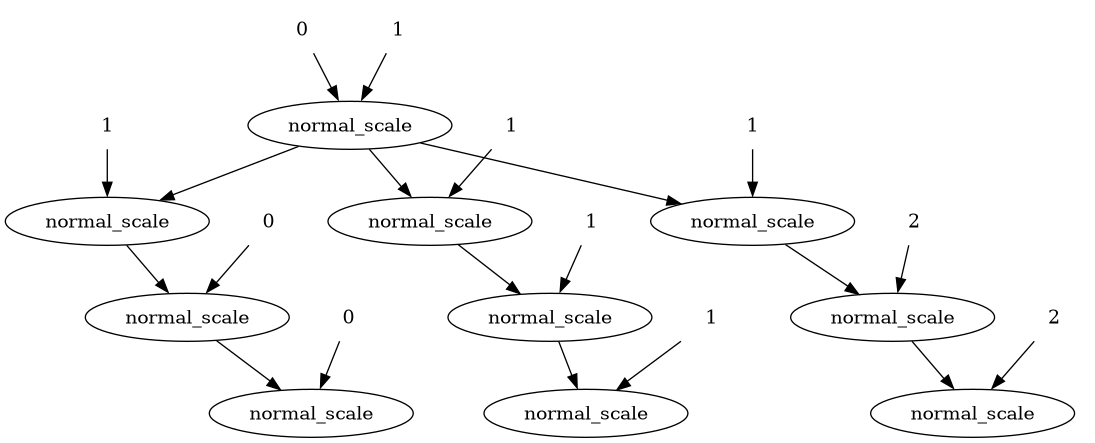

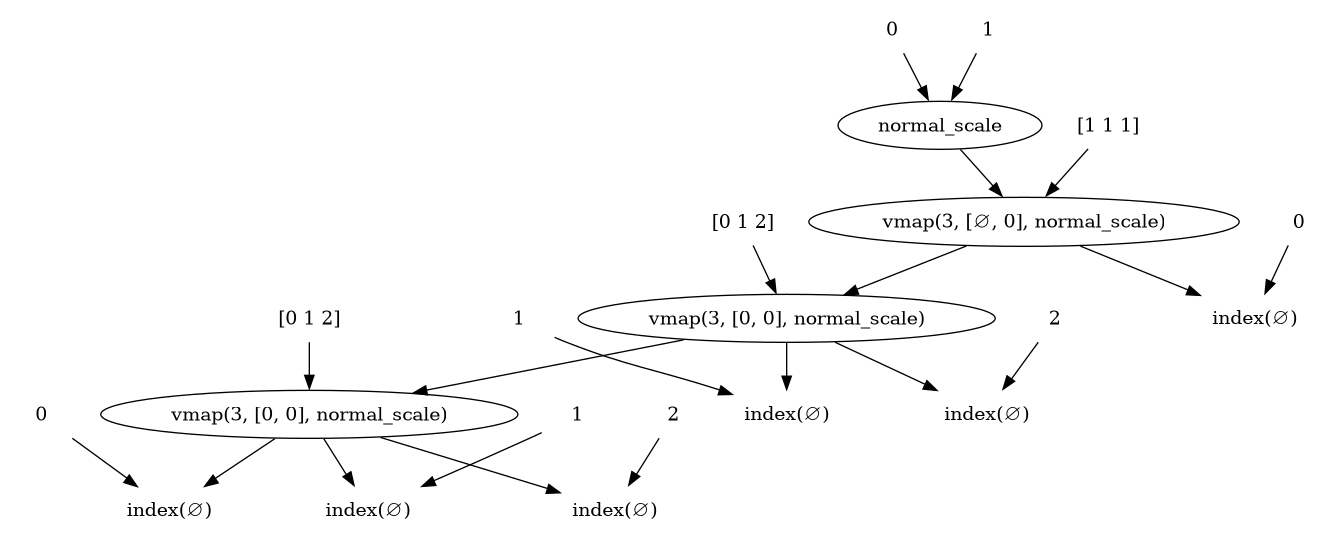

In [50]:
z = normal_scale(0, 1)
y = [normal_scale(z, 1) for _ in range(3)]
x1 = [normal_scale(y[i], i) for i in range(3)]
x2 = [normal_scale(x1[i], i) for i in range(3)]
display(viz_upstream(x2 + x1))
display(viz_upstream(AutoVmapWrap(x2 + x1[1:3] + y[:1], order=-1)))

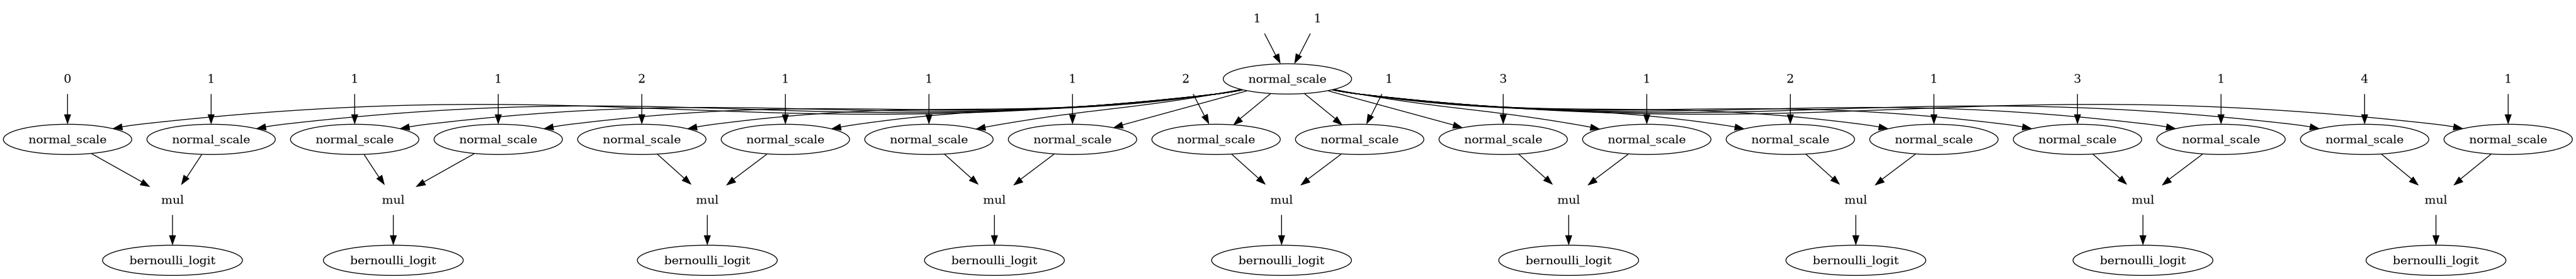

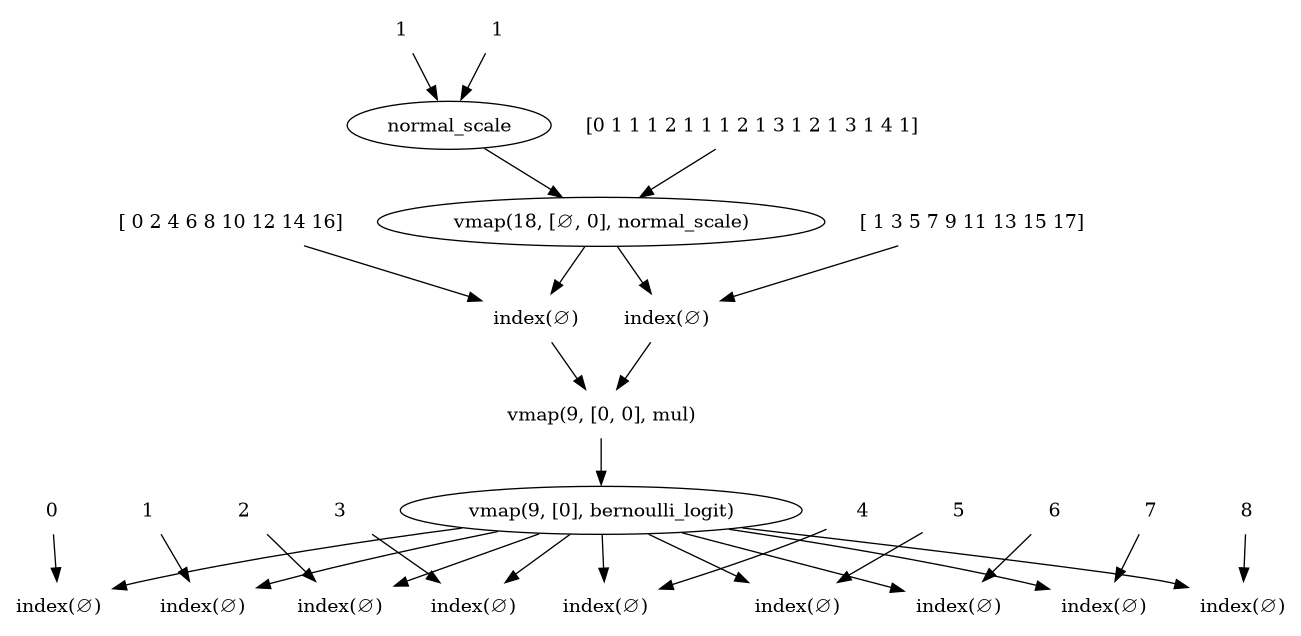

In [42]:
x = normal_scale(1, 1)
y = {}
z = {}
for i in range(3):
    for j in range(3):
        y[(i, j)] = normal_scale(x, i + j)
        z[(i, j)] = normal_scale(x, 1)
        
O = {}
for i in range(3):
    for j in range(3):
        O[(i, j)] = bernoulli_logit(y[(i, j)] * z[i, j])
display(viz_upstream(O))
display(viz_upstream(AutoVmapWrap(O, order=-1)))

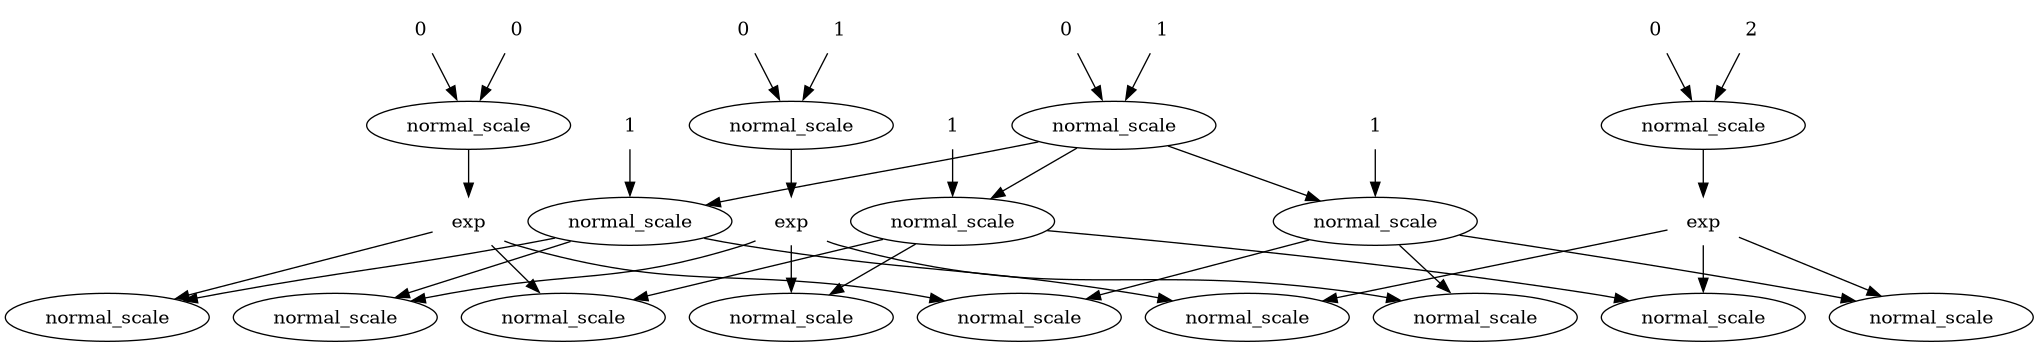

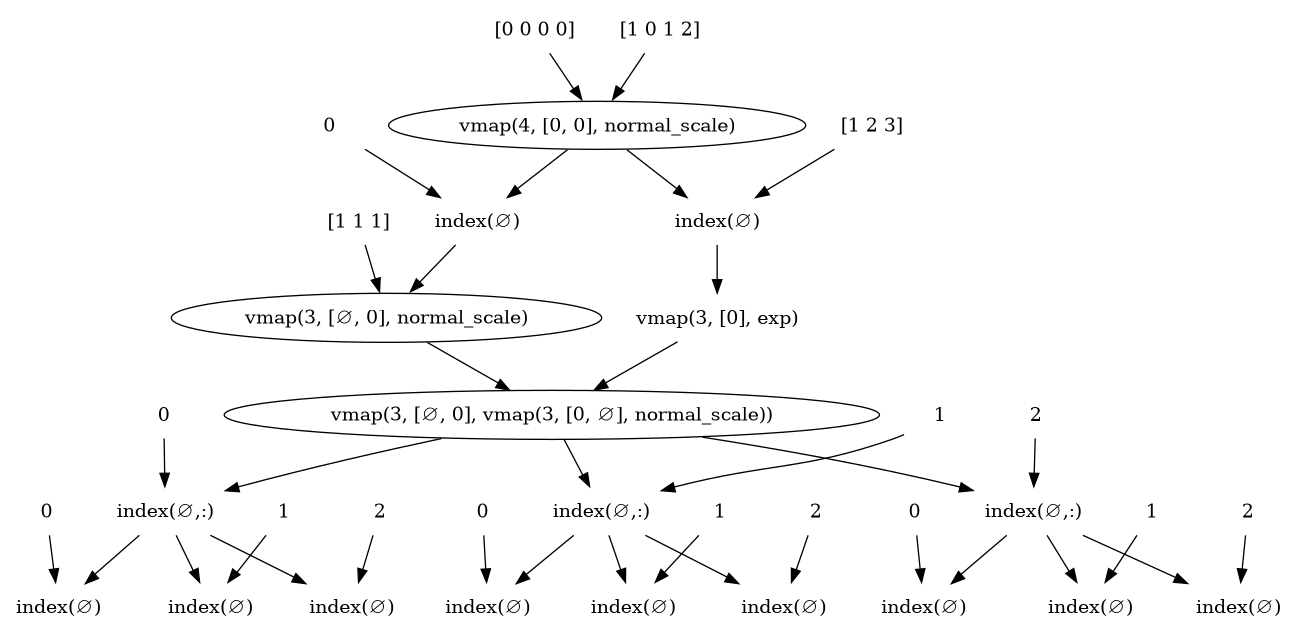

In [57]:
v = [normal(0, i) for i in range(3)]
u = [exp(vj) for vj in v]
x = normal(0, 1)
y = [normal(x, 1) for i in range(3)]
z = [[normal(yi, uj) for yi in y] for uj in u]

display(viz_upstream(z))
display(viz_upstream(AutoVmapWrap(z, order=-1)))

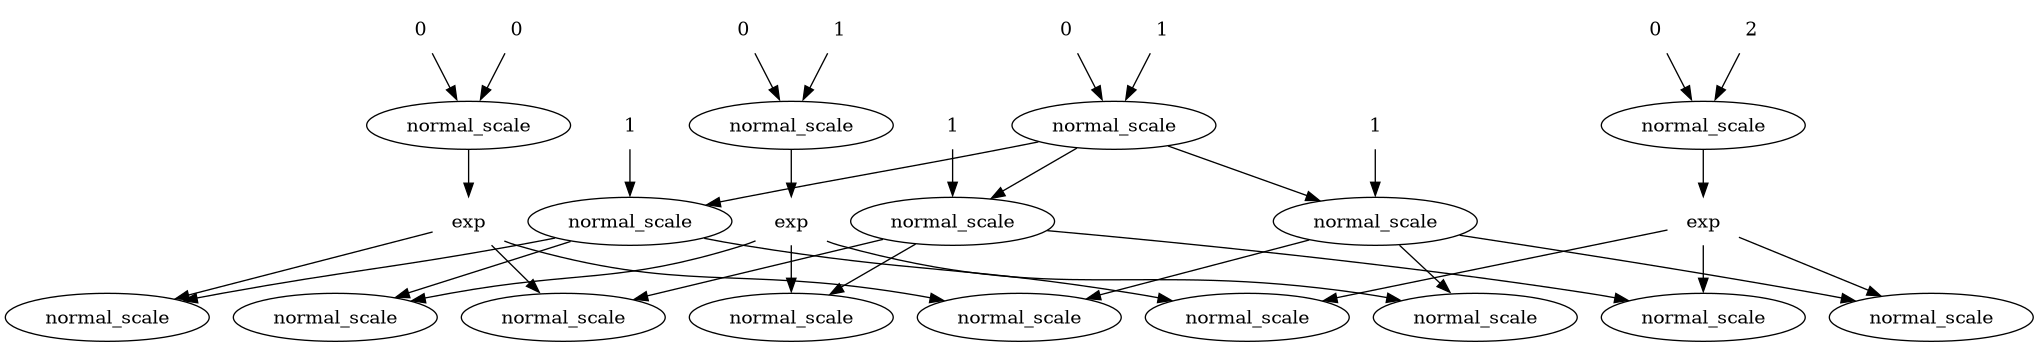

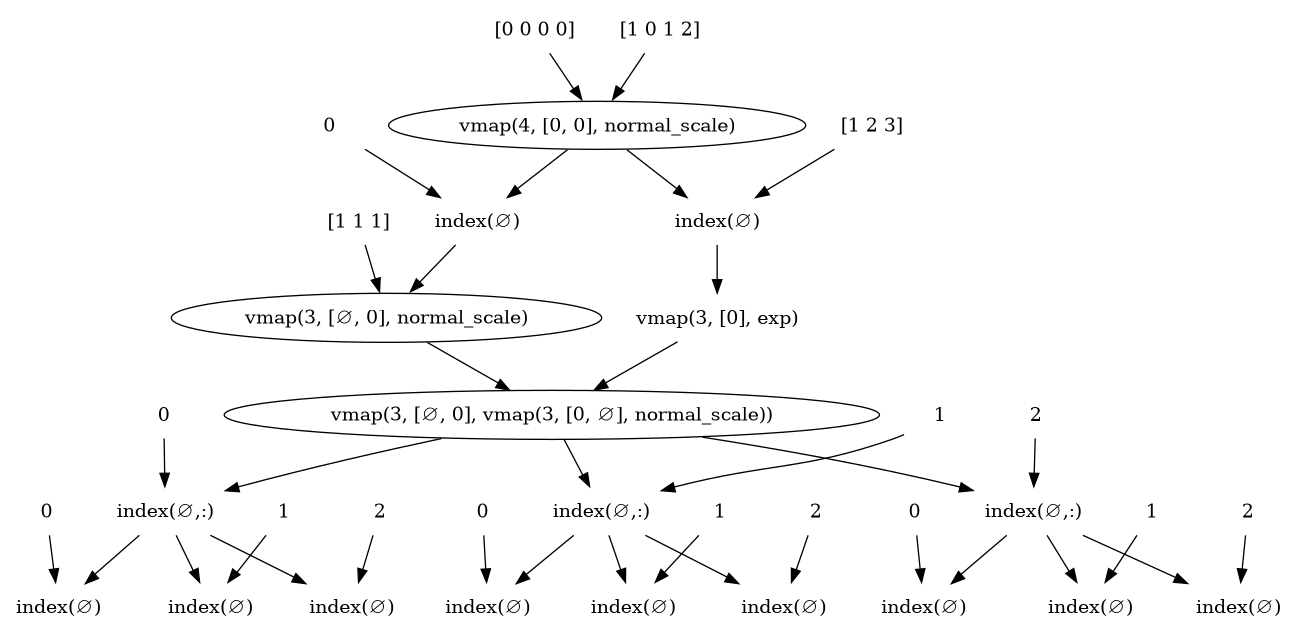

In [58]:
v = [exp(normal(0, i)) for i in range(3)]
x = normal(0, 1)
y = [normal(x, 1) for i in range(3)]
z = [[normal(yi, vj) for yi in y] for vj in v]

display(viz_upstream(z))
display(viz_upstream(AutoVmapWrap(z, order=-1)))

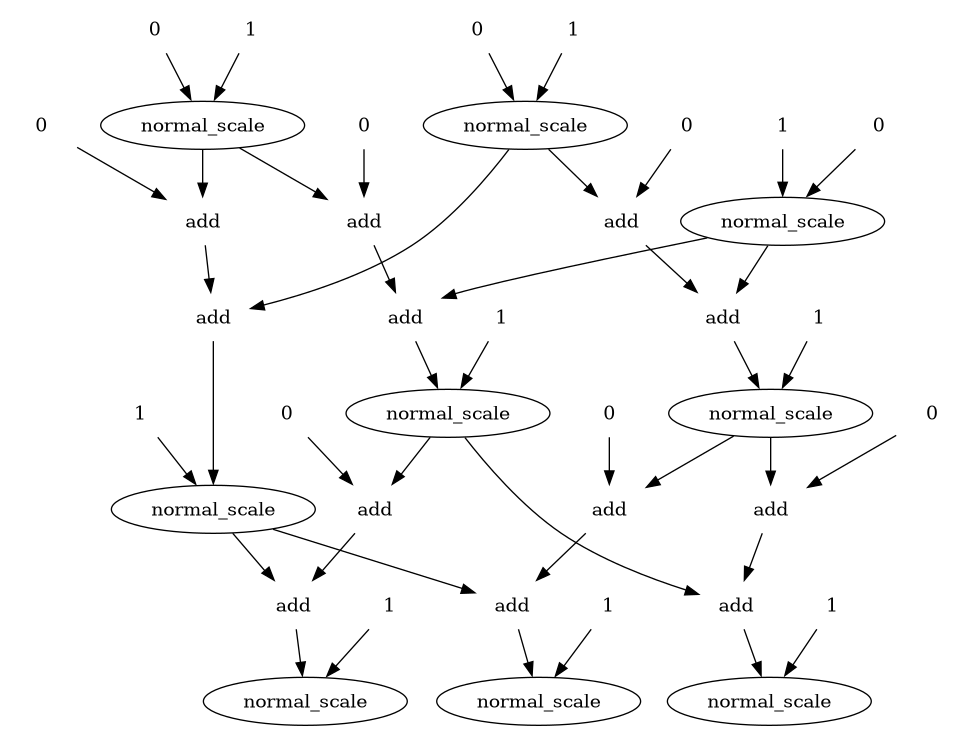

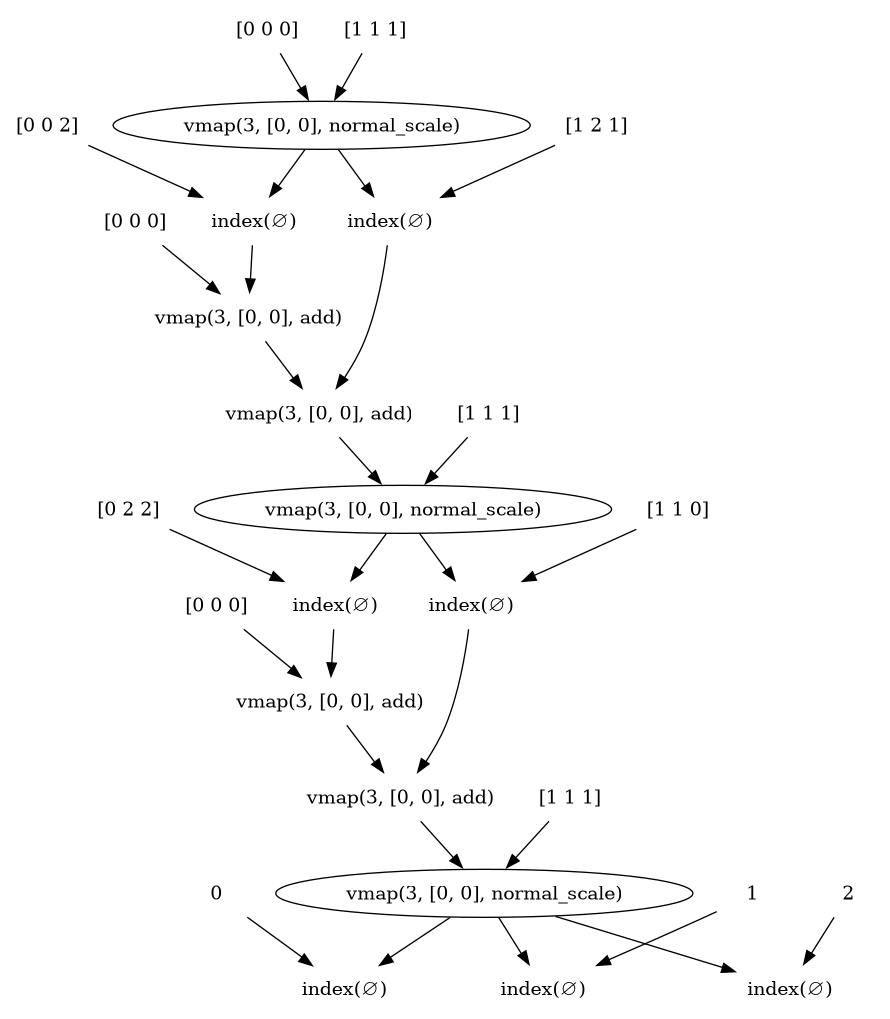

In [61]:
D = 3
x = [normal_scale(0, 1) for _ in range(D)]
h1 = [normal_scale(sum(x[:i] + x[i + 1:]), 1) for i in range(D)]
h2 = [normal_scale(sum(h1[:i] + h1[i + 1:]), 1) for i in range(D)]
display(viz_upstream(h2))
display(viz_upstream(AutoVmapWrap(h2, order=0)))

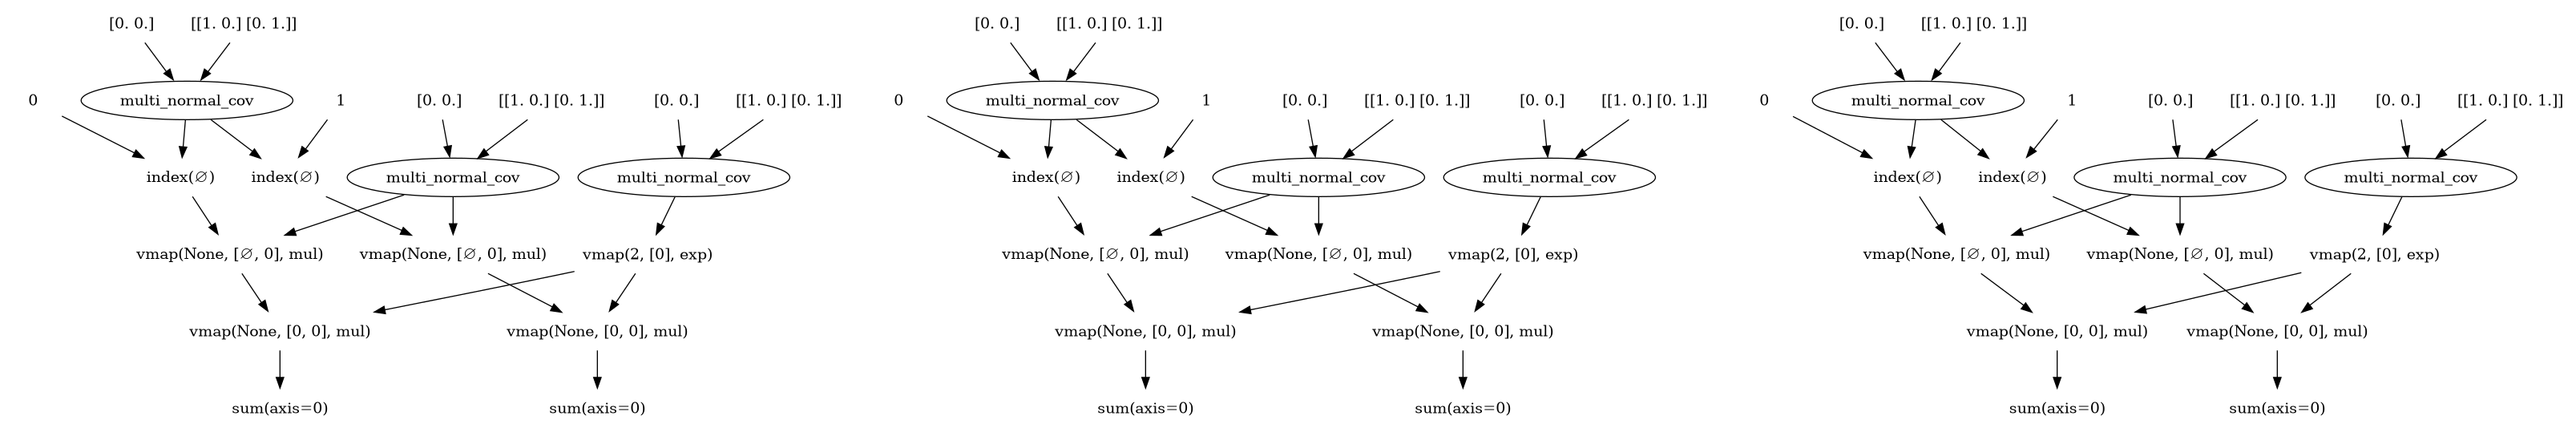

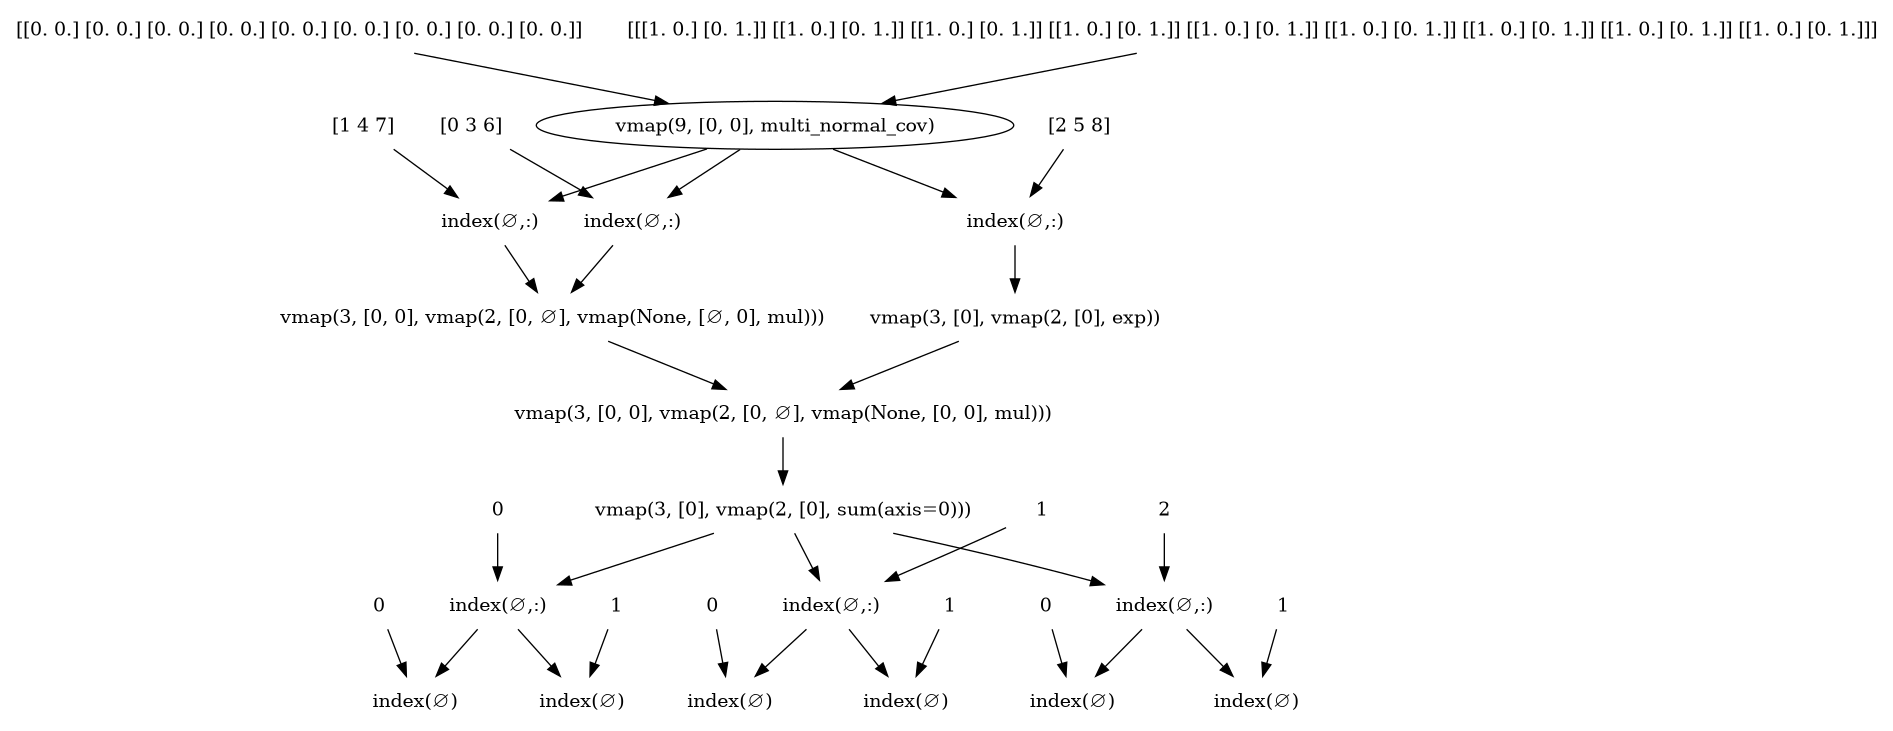

In [63]:
# Attention???

B = 3 # Batch size
T = 2 # sequence length

Q = [multi_normal_cov(np.zeros(T), np.eye(T)) for _ in range(B)] # Queries
K = [multi_normal_cov(np.zeros(T), np.eye(T)) for _ in range(B)] # Keys
V = [vmap(exp)(multi_normal_cov(np.zeros(T), np.eye(T))) for _ in range(B)] # Values

outputs = []
for b in range(B): # b: Batch ID
    output = []
    for t in range(T):
        q = Q[b][t] # The t_th token for query of the b_th sample.
        k = K[b] # Keys of the b_th sample
        similarity_score = q * k # q * k denotes the similarity score
        output.append(
            Sum(0)(similarity_score * V[b]) # sum(score_t * value)
        )
    outputs.append(output)
    
display(viz_upstream(outputs))
display(viz_upstream(AutoVmapWrap(outputs, order=-1)))

## Try some multivariate stuff?

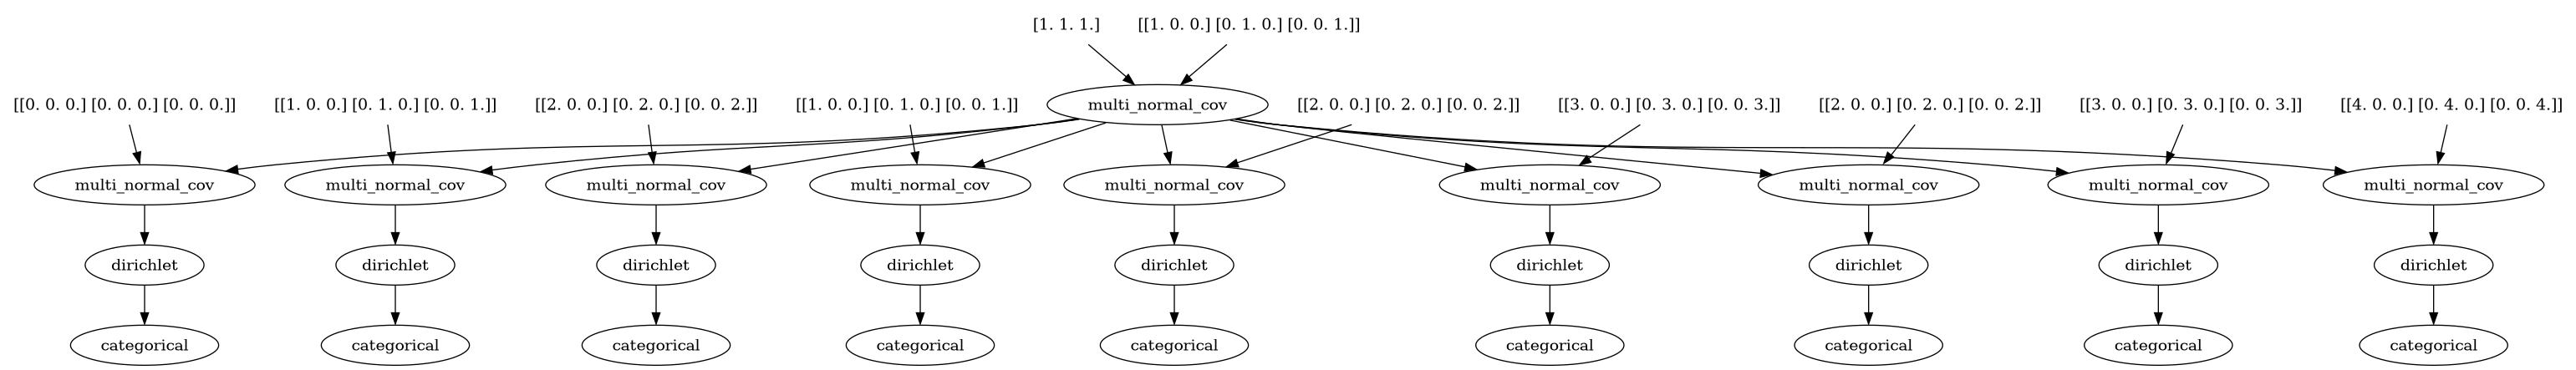

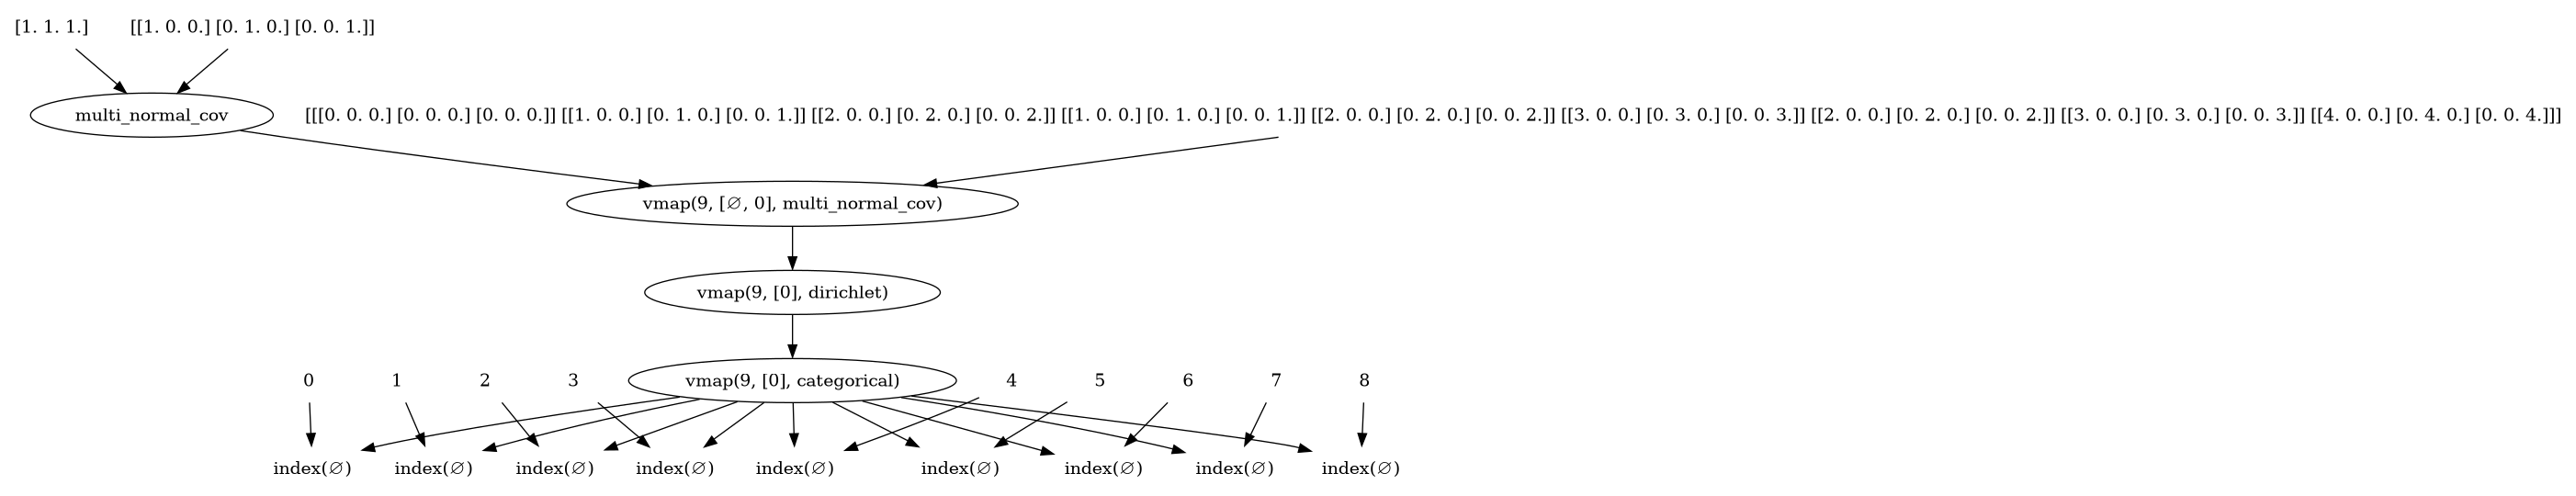

In [33]:
D = 3
x = multi_normal_cov(np.ones(D,), np.eye(3))
y = {}
for i in range(3):
    for j in range(3):
        y[(i, j)] = multi_normal_cov(x, (i + j) * np.eye(3))
        
O = {}
for i in range(3):
    for j in range(3):
        O[(i, j)] = categorical(dirichlet(y[(i, j)]))
display(viz_upstream(O))
display(viz_upstream(AutoVmapWrap(O, order=-1)))

## GP

In [34]:
ndata = 20
σ = 1.5
x_obs = np.random.rand(ndata)*10
y_obs = x_obs * np.sin(x_obs) + σ * np.random.randn(ndata)

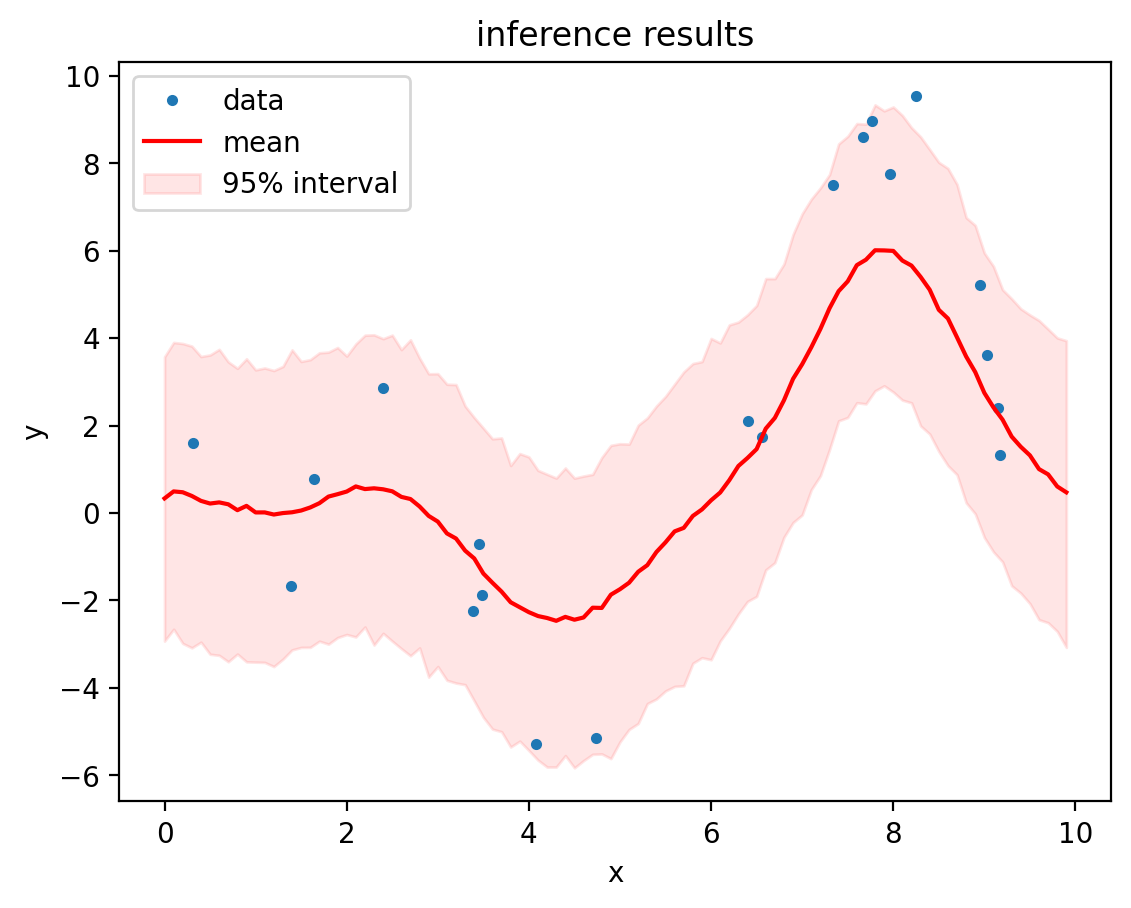

In [37]:
# Manual vmap
x_test = np.arange(0,10,.1)
x = np.concatenate([x_obs,x_test])

# kernel function
def kernel(x):
    N = len(x)
    K = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            K[i,j] = np.exp(-1*(x[i]-x[j])**2)
    # make PSD
    return .5*(K+K.T) + .1*np.eye(N)

# compute kernel
K = kernel(x)

# define model
z = multi_normal_cov(np.zeros(len(x)),K)
y_train = vmap(normal,(0,None))(z[:ndata],σ)
y_test = vmap(normal,(0,None))(z[ndata:],σ)

# do inference
calc = Calculate("numpyro",niter=1000)
ys = calc.sample(y_test,y_train,y_obs)

# plot
y_pred = np.mean(ys,axis=0)
y_lo = np.quantile(ys,.025,axis=0)
y_hi = np.quantile(ys,.975,axis=0)

plt.plot(x_obs,y_obs,'.',label='data')
plt.plot(x_test,y_pred,'r-',label='mean')
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.1,label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('inference results')
plt.legend();

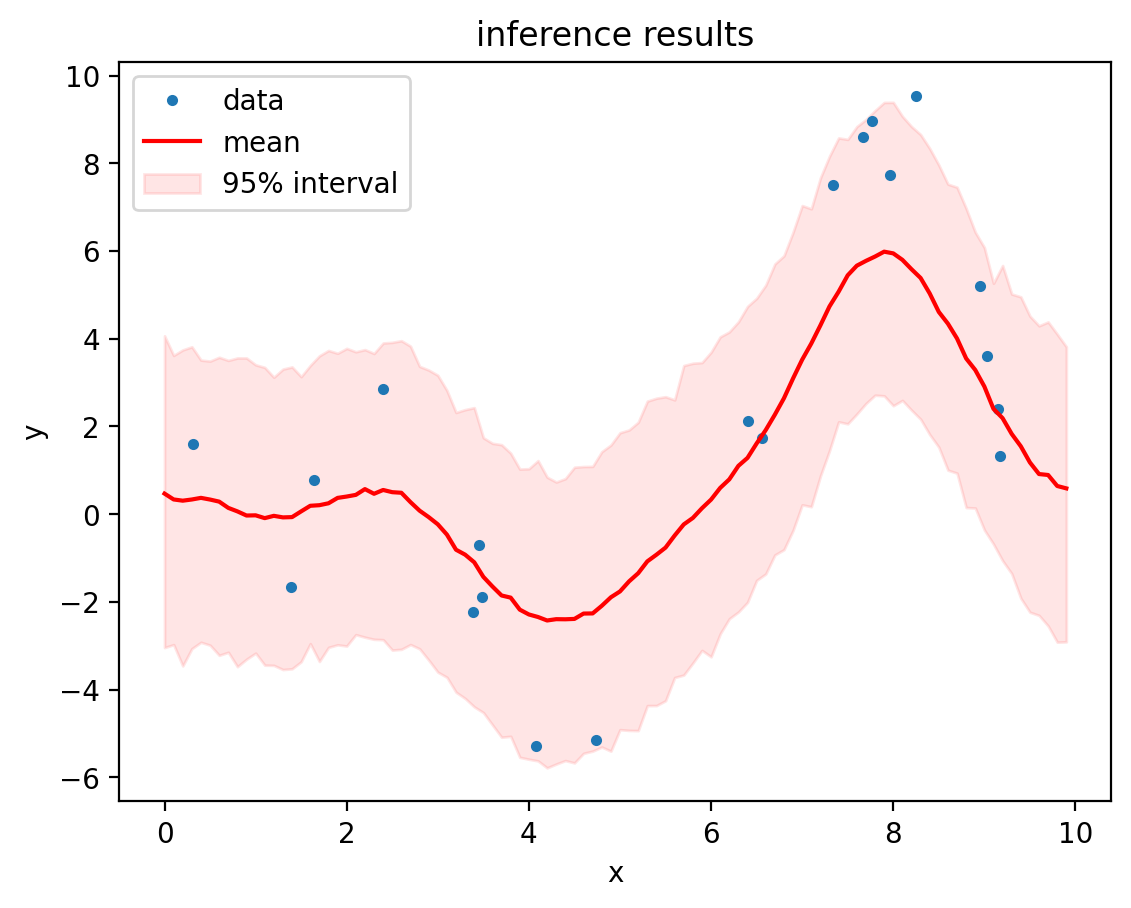

In [40]:
# AutoVmap

z = multi_normal_cov(np.zeros(len(x)),K)
y_train = []
for i in range(ndata):
    y_train.append(normal_scale(z[i], σ))

y_test = []
for j in range(len(x_test)):
    y_test.append(normal_scale(z[ndata + j], σ))

tvars, tgvars, tgvals = AutoVmap(y_test, y_train, list(y_obs))

calc = Calculate("numpyro",niter=1000)
ys = calc.sample(tvars,tgvars,tgvals)
ys = np.array(ys).T

# plot
y_pred = np.mean(ys,axis=0)
y_lo = np.quantile(ys,.025,axis=0)
y_hi = np.quantile(ys,.975,axis=0)

plt.plot(x_obs,y_obs,'.',label='data')
plt.plot(x_test,y_pred,'r-',label='mean')
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.1,label='95% interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('inference results')
plt.legend();